# Import and install necessary libraries

In [ ]:
%pip install torch torchvision numpy pandas matplotlib sklearn

In [1]:
import numpy as np
import pandas

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Prepare the data

In [7]:
!unzip "/content/fer2013.zip" -d "/content/fer2013"


Streaming output truncated to the last 5000 lines.
 extracting: /content/fer2013/fer2013/train/sad/Training_65267116.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65275626.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_6529266.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65329617.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65338712.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65338797.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65387162.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65404494.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65426218.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65430136.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65437377.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_6545735.jpg  
 extracting: /content/fer2013/fer2013/train/sad/Training_65463385.jpg  
 extracting: /c

In [8]:
arr = [1, 2, 3]


In [9]:
class FER2013Dataset(Dataset):
  def __init__(self, dir, transform=None):
    self.classes = {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
    self.root_dir = dir
    self.transform = transform
    self.images = self.load_images()

  def load_images(self):
    images = []
    for class_name, class_index in self.classes.items():
      # class_path = f'{self.root_dir}/{class_name}'
      class_path = os.path.join(self.root_dir, class_name)
      for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        images.append((image_path, class_index))
    return images

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path, label = self.images[idx]
    image = Image.open(image_path)

    if self.transform:
      image = self.transform(image)

    return image, label

In [10]:
transform = transforms.Compose([
    # transforms.Resize((48, 48)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x/255.0),
    # transforms.Normalize(0.5, 0.5)
])

dataset_folder = './fer2013/fer2013'

fer_dataset = FER2013Dataset(dir=os.path.join(dataset_folder, 'train'), transform=transform)
test_dataset = FER2013Dataset(dir=os.path.join(dataset_folder, 'test'), transform=transform)

train_len = int(len(fer_dataset) * 0.8)
val_len = len(fer_dataset) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(fer_dataset, [train_len, val_len])

b_size = 32
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=b_size, shuffle=True)

In [11]:
train_len, val_len

(22618, 5655)

In [12]:
len(train_dataset), len(val_dataset)

(22618, 5655)

In [13]:
train_dataset[0]

(tensor([[[0.9412, 0.9725, 0.9961,  ..., 0.6784, 0.7059, 0.7255],
          [0.9882, 0.9059, 0.4000,  ..., 0.6863, 0.7098, 0.7490],
          [0.8000, 0.1843, 0.0353,  ..., 0.7059, 0.6941, 0.7255],
          ...,
          [0.9412, 0.9373, 0.9451,  ..., 0.5922, 0.6431, 0.7569],
          [0.9333, 0.9490, 0.9451,  ..., 0.7098, 0.7725, 0.7961],
          [0.9294, 0.9412, 0.9451,  ..., 0.8196, 0.8157, 0.7765]]]),
 0)

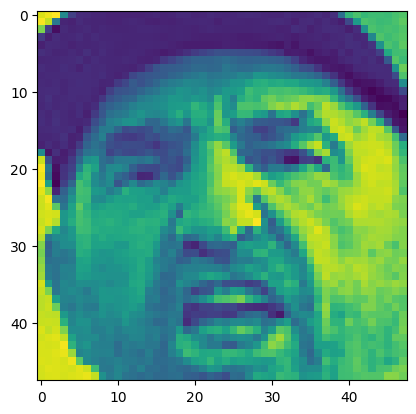

In [14]:
plt.imshow(train_dataset[0][0][0])

# Build the model

In [15]:
class CNNModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Flatten(),

        nn.Linear(9216, 256),
        nn.ReLU(),

        nn.Linear(256, 128),
        nn.ReLU(),

        nn.Linear(128, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.model(x)
    return x

model = CNNModel(num_classes=6).to(device)

In [16]:
model

CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=9216, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=6, bias=True)
    (14): Softmax(dim=1)
  )
)

# Train the model

In [17]:
def save_checkpoint(lr, epoch, model, optimizer, filepath):
  checkpoint = {
      'lr': lr,
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }
  torch.save(checkpoint, filepath)

In [ ]:
# learning rates
lr_values = [0.0005, 0.001, 0.005, 0.01]

In [ ]:
def grid_search(num_epochs, lr_values):
  criterion = nn.CrossEntropyLoss()
  all_loss_history = {}
  all_train_accuracy_history = {}
  all_val_accuracy_history = {}
  
  for learn_rate in lr_values:
    print(f"-----LEARNING RATE: {learn_rate}-----")
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    loss_history, train_accuracy_history, val_accuracy_history = train(num_epochs, learn_rate, optimizer, criterion)
    all_loss_history[learn_rate] = loss_history
    all_train_accuracy_history[learn_rate] = train_accuracy_history
    all_val_accuracy_history[learn_rate] = val_accuracy_history
  return all_loss_history, all_train_accuracy_history, all_val_accuracy_history


def train(num_epochs, lr, optimizer, criterion):
  # plotting after training
  loss_history = []
  train_accuracy_history = []
  val_accuracy_history = []

  for epoch in range(num_epochs):
    model.train()
    # evaluating during training
    running_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_loader:
      # start train
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # end train

      total_correct_train += (predicted == labels).sum().item()
      total_samples_train += labels.size(0)

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy_train = total_correct_train / total_samples_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%')

    loss_history.append(epoch_loss)
    train_accuracy_history.append(accuracy_train)

    save_checkpoint(lr, epoch, model, optimizer, f'./checkpoints/checkpoint_lr_{lr}_epoch_{epoch}.pth')

    model.eval()
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
      for images, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_correct_val += (predicted == labels).sum().item()
        total_samples_val += labels.size(0)

    accuracy_val = total_correct_val / total_samples_val
    print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")
    val_accuracy_history.append(accuracy_val)

  return loss_history, train_accuracy_history, val_accuracy_history

In [ ]:
loss, train_acc, val_acc = grid_search(num_epochs=20, lr_values=lr_values)

Epoch [1/2], Loss: 1.6162, Training Accuracy: 41.14%
Validation Accuracy: 41.13%
Epoch [2/2], Loss: 1.5950, Training Accuracy: 43.57%
Validation Accuracy: 41.64%


In [ ]:
def load_checkpoint(model, optimizer, filepath):
  checkpoint = torch.load(filepath)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  # lr = checkpoint['lr']
  return model, optimizer, epoch

check_epoch = 15
loaded_model, loaded_optimizer, start_epoch = load_checkpoint(model, optimizer, f'./checkpoints/checkpoint_epoch_{check_epoch}.pth')

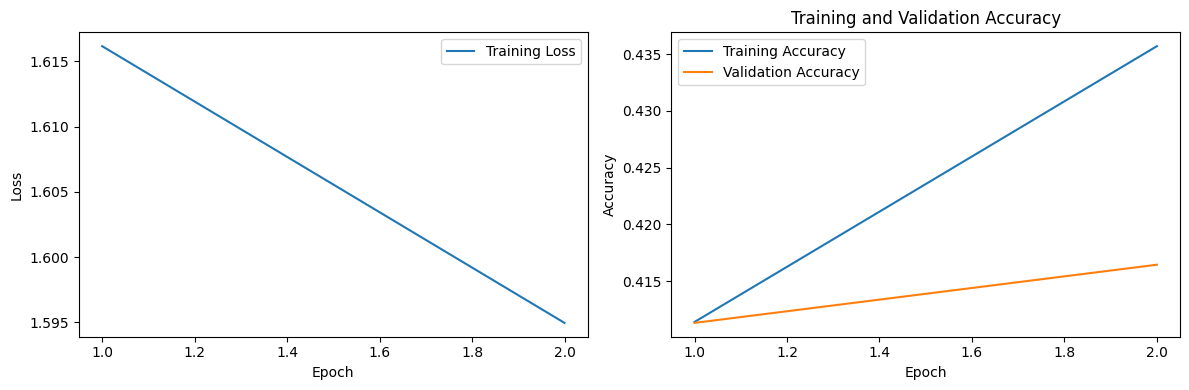

In [26]:
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Saving the trained model

In [28]:
torch.save(model.state_dict(), './models/model_ready.pth')

In [33]:
model = CNNModel(num_classes=6).to(device)
model.load_state_dict(torch.load('./models/model_ready.pth'))
model.eval()

CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=9216, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=6, bias=True)
    (14): Softmax(dim=1)
  )
)

# Testing and evaluating the model

In [29]:
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

Accuracy: 43.44%
Precision: 44.03%
Recall: 43.44%
F1 Score: 39.39%
Classification Report:
              precision    recall  f1-score   support

       angry       0.35      0.10      0.16       958
        fear       0.41      0.08      0.13      1024
       happy       0.49      0.78      0.60      1774
     neutral       0.45      0.31      0.37      1233
         sad       0.30      0.55      0.39      1247
    surprise       0.67      0.53      0.59       831

    accuracy                           0.43      7067
   macro avg       0.45      0.39      0.37      7067
weighted avg       0.44      0.43      0.39      7067

Confusion Matrix:
[[  97   33  329  103  360   36]
 [  56   81  286  104  390  107]
 [  25   11 1389   68  250   31]
 [  27   17  361  382  422   24]
 [  44   20  339  142  683   19]
 [  31   34  139   50  139  438]]


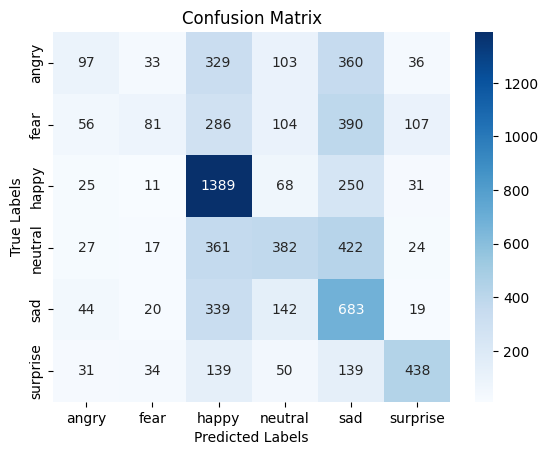

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
labels_true, labels_pred = evaluate_model(model, test_loader, device)

# Calculate accuracy
accuracy = accuracy_score(labels_true, labels_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score for each class
precision = precision_score(labels_true, labels_pred, average='weighted')
recall = recall_score(labels_true, labels_pred, average='weighted')
f1 = f1_score(labels_true, labels_pred, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Print classification report and confusion matrix
class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print("Classification Report:")
print(classification_report(labels_true, labels_pred, target_names=class_names))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(labels_true, labels_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
@torch.no_grad()
def predict(model, img_path, transform=None):
  img = Image.open(img_path) # load image
  plt.imshow(img)
  plt.title("Input image")
  plt.show()

  if transform: # apply transform
    img = transform(img)
    print(img)

  img = img.unsqueeze(0) # Add a batch dimension
  img = img.to(device)
  model.eval()

  output = model(img)
  _, result = torch.max(output, 1)

  class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'] # Can make a global variable
  prediction = class_names[result.item()]
  print(np.array(output[0].to('cpu')))

  return prediction

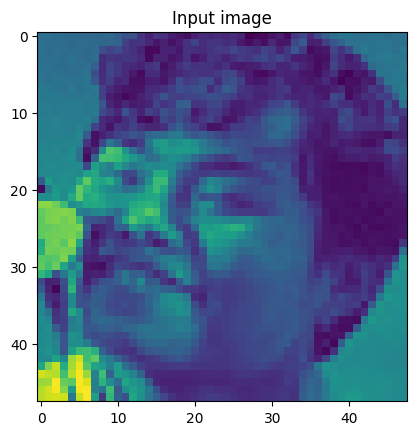

tensor([[[0.3608, 0.3686, 0.3529,  ..., 0.3647, 0.3843, 0.3765],
         [0.3765, 0.3608, 0.3647,  ..., 0.3882, 0.3725, 0.3725],
         [0.3725, 0.3569, 0.3725,  ..., 0.3961, 0.3725, 0.4039],
         ...,
         [0.8471, 0.8588, 0.9961,  ..., 0.4941, 0.4824, 0.4745],
         [0.8863, 0.9333, 0.9882,  ..., 0.4941, 0.4863, 0.4784],
         [0.8941, 0.9255, 0.9373,  ..., 0.4863, 0.4863, 0.4824]]])
[7.9035977e-05 2.2951973e-04 4.4959150e-03 2.4927281e-02 9.7026795e-01
 2.1355032e-07]
sad


In [32]:
print(predict(model, '/content/fer2013/fer2013/test/happy/PrivateTest_10470092.jpg', transform=transform))